In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
stock = pd.read_csv("stocks_data/NAVER.csv") #(2017-06-01~2022-06-01) 네이버
stock = stock.set_index(keys=['Date'], inplace=False, drop=True)

In [3]:
pd.isnull(stock).sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [4]:
stock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-10-29,1797.724854,1797.724854,1797.724854,1797.724854,501745.0,1761.037598
2002-10-30,2012.226074,1989.754517,2012.226074,2012.226074,20892185.0,1971.161011
2002-10-31,2091.897949,1865.139526,2042.869141,1912.125488,32327083.0,1873.103516
2002-11-01,2022.440430,1724.181519,1961.154419,1793.639038,18373668.0,1757.035034
2002-11-04,1789.553345,1660.852539,1777.296143,1703.752808,16939411.0,1668.982910
...,...,...,...,...,...,...
2022-05-25,268500.000000,262500.000000,266500.000000,266000.000000,533307.0,266000.000000
2022-05-26,272500.000000,266000.000000,269500.000000,266000.000000,541194.0,266000.000000
2022-05-27,272000.000000,268500.000000,271000.000000,270000.000000,481191.0,270000.000000


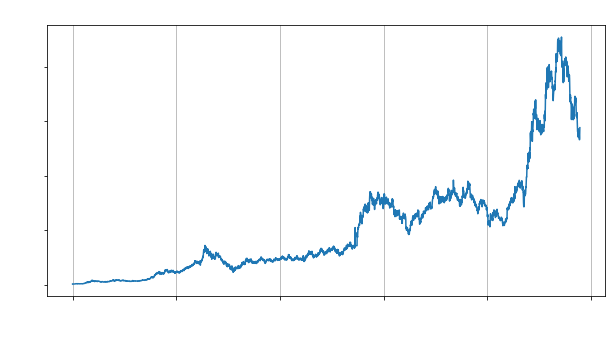

In [5]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize = (10,5))
ax = plt.subplot()
plt.title("종가(2002-10-29~2022-06-01)", fontsize=15, color = 'white')
plt.plot(stock['Close'], "-", label="Close")
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
plt.xticks(rotation=45)
plt.grid(axis = 'x')
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scale_cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
# #scale_cols = ['High', 'Low', 'Open', 'Close', 'Adj Close']
# scaled = scaler.fit_transform(stock[scale_cols])
# #scaled = scaler.fit_transform(kakao['Volume'])
# scaled_df = pd.DataFrame(scaled, columns=scale_cols)
# scaled_df
# 피처값 스케일링
scaler = MinMaxScaler()

scaled_df = pd.DataFrame()
scaled_df[['High', 'Low', 'Open', 'Volume', 'Adj Close']] = scaler.fit_transform(stock[['High', 'Low', 'Open', 'Volume', 'Adj Close']])

# 타켓 스케일링
scaler1 = MinMaxScaler()
scaled_df['Close'] = scaler1.fit_transform(stock['Close'].values.reshape(-1,1))

# 스케일링 결과 확인
scaled_df



,High,Low,Open,Volume,Adj Close,Close
0,0.000494,0.000771,0.000579,0.013855,0.000655,0.000668
1,0.000957,0.001197,0.001047,0.576913,0.001120,0.001142
2,0.001128,0.000920,0.001114,0.892674,0.000903,0.000921
3,0.000979,0.000608,0.000936,0.507367,0.000646,0.000659
4,0.000476,0.000467,0.000535,0.467762,0.000452,0.000460
...,...,...,...,...,...,...
4887,0.575989,0.579403,0.577942,0.014727,0.585343,0.584535
4888,0.584620,0.587171,0.584486,0.014944,0.585343,0.584535
4889,0.583541,0.592720,0.587757,0.013288,0.594194,0.593374
4890,0.606198,0.603817,0.594301,0.020743,0.618534,0.617683


In [9]:
TEST_SIZE = 200
train = scaled_df[:-TEST_SIZE]
test = scaled_df[-TEST_SIZE:]

In [10]:
train.shape, test.shape

((4692, 6), (200, 6))

In [11]:
window_size = 20
def make_dataset(feature, label, window_size):
    feature_list = []
    label_list = []

    for i in range(len(feature) - window_size) :
        feature_list.append(feature.iloc[i:i+window_size])
        label_list.append(label.iloc[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [12]:
feature_cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label,window_size)

test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature , test_label = make_dataset(test_feature, test_label,window_size)

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_feature, train_label, test_size=0.3) 
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(3270, 20, 5) (1402, 20, 5)
(3270, 1) (1402, 1)


In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu')
          )
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_test, y_test), 
                    callbacks=[early_stop])


Epoch 1/200
205/205 [==============================] - 10s 15ms/step - loss: 0.0046 - val_loss: 1.5894e-04
Epoch 2/200
205/205 [==============================] - 3s 12ms/step - loss: 1.3503e-04 - val_loss: 9.9992e-05
Epoch 3/200
205/205 [==============================] - 3s 12ms/step - loss: 1.0863e-04 - val_loss: 9.0260e-05
Epoch 4/200
205/205 [==============================] - 2s 11ms/step - loss: 1.0441e-04 - val_loss: 8.1740e-05
Epoch 5/200
205/205 [==============================] - 2s 10ms/step - loss: 9.2962e-05 - val_loss: 8.8067e-05
Epoch 6/200
205/205 [==============================] - 2s 9ms/step - loss: 8.6868e-05 - val_loss: 8.9843e-05
Epoch 7/200
205/205 [==============================] - 2s 10ms/step - loss: 8.9864e-05 - val_loss: 8.0438e-05
Epoch 8/200
205/205 [==============================] - 2s 10ms/step - loss: 9.8988e-05 - val_loss: 9.4552e-05
Epoch 9/200
205/205 [==============================] - 2s 9ms/step - loss: 8.4000e-05 - val_loss: 7.1967e-05
Epoch 10/200
20

In [16]:
test_label.shape

(180, 1)

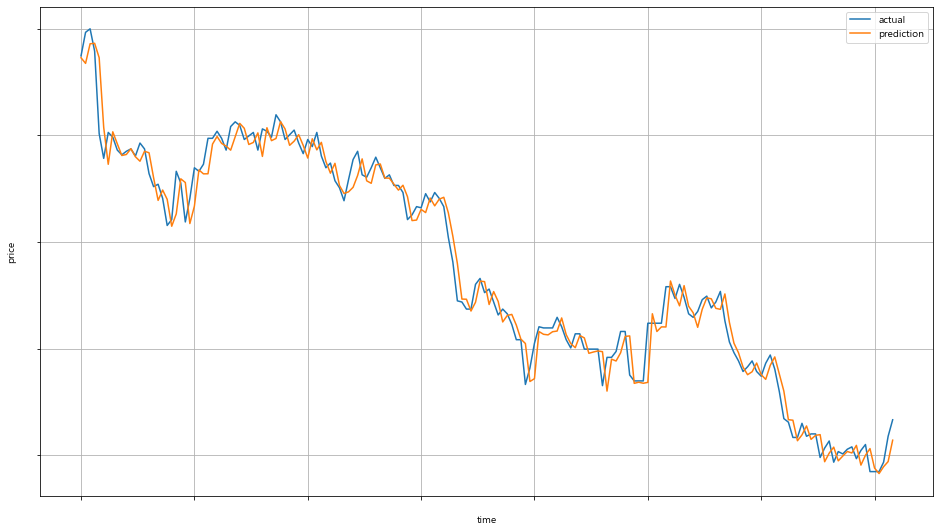

In [17]:
pred = model.predict(test_feature)

plt.figure(figsize = (16,9))
plt.xlabel("time")
plt.ylabel("price")
plt.plot(test_label, label="actual")
plt.plot(pred, label="prediction")
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
plt.grid()
plt.legend(loc="best")
plt.show()

In [18]:
pred.shape

(180, 1)

In [19]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(test_label, pred):.3f}")

def MPE(y_test, y_pred): 
    return np.mean((y_test - y_pred) / y_test) * 100
print(f"MPE: {MPE(test_label, pred):.3f}")

def MAE(y_test, y_pred):
    return np.mean(np.abs(y_test - y_pred))

print(f"MAE: {MAE(test_label, pred):.3f}")

def MSE(y_test, y_pred):
    return np.mean(np.square((test_label - pred)))

print(f"MSE: {MSE(test_label, pred):.3f}")

print(f"RMSE: {np.sqrt(MSE(test_label, pred)):.3f}")

MAPE: 1.538
MPE: 0.120
MAE: 0.012
MSE: 0.000
RMSE: 0.016


In [ ]:
window_size = 50
train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label,window_size)

test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature , test_label = make_dataset(test_feature, test_label,window_size)

x_train, x_test, y_train, y_test = train_test_split(train_feature, train_label, test_size=0.3) 
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

In [20]:
model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu')
          )
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, 
                    epochs=250, 
                    batch_size=60,
                    validation_data=(x_test, y_test), 
                    callbacks=[early_stop])

Epoch 1/250
55/55 [==============================] - 2s 11ms/step - loss: 0.0227 - val_loss: 8.4924e-04
Epoch 2/250
55/55 [==============================] - 0s 7ms/step - loss: 4.4702e-04 - val_loss: 2.1946e-04
Epoch 3/250
55/55 [==============================] - 0s 7ms/step - loss: 1.5085e-04 - val_loss: 1.1427e-04
Epoch 4/250
55/55 [==============================] - 0s 8ms/step - loss: 1.0783e-04 - val_loss: 8.9954e-05
Epoch 5/250
55/55 [==============================] - 1s 9ms/step - loss: 9.5046e-05 - val_loss: 9.7769e-05
Epoch 6/250
55/55 [==============================] - 0s 8ms/step - loss: 9.0548e-05 - val_loss: 7.9249e-05
Epoch 7/250
55/55 [==============================] - 1s 9ms/step - loss: 9.0494e-05 - val_loss: 9.1513e-05
Epoch 8/250
55/55 [==============================] - 0s 8ms/step - loss: 8.6547e-05 - val_loss: 8.3456e-05
Epoch 9/250
55/55 [==============================] - 0s 9ms/step - loss: 8.1156e-05 - val_loss: 9.1463e-05
Epoch 10/250
55/55 [====================

In [ ]:
# model = Sequential()
# model.add(LSTM(32,return_sequences=True, 
#                input_shape=(train_feature.shape[1], train_feature.shape[2]), 
#                activation='relu')
#           )
# model.add(LSTM(64))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# early_stop = EarlyStopping(monitor='val_loss', patience=10)
# history = model.fit(x_train, y_train, 
#                     epochs=300, 
#                     batch_size=30,
#                     validation_data=(x_test, y_test), 
#                     callbacks=[early_stop])


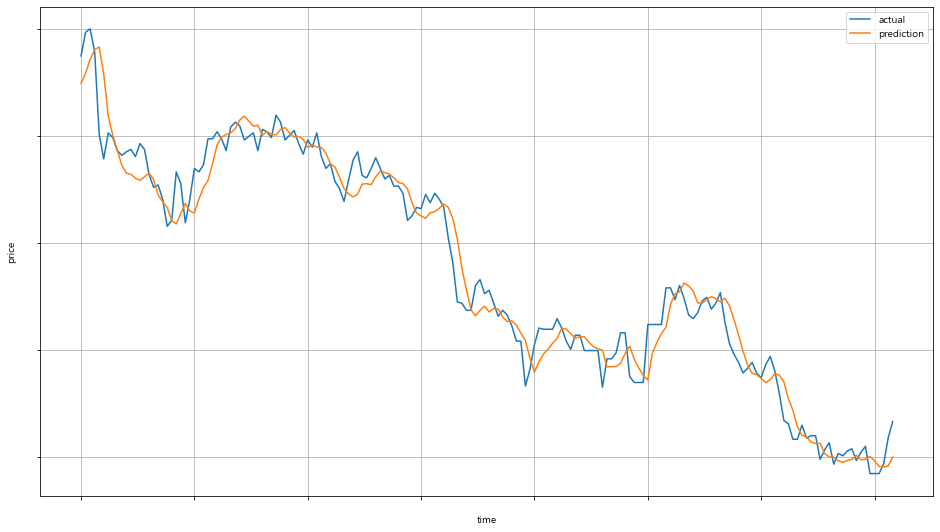

In [21]:
pred = model.predict(test_feature)

plt.figure(figsize = (16,9))
plt.xlabel("time")
plt.ylabel("price")
plt.plot(test_label, label="actual")
plt.plot(pred, label="prediction")
plt.tick_params(axis='x', labelcolor='white')
plt.tick_params(axis='y', labelcolor='white')
plt.grid()
plt.legend(loc="best")
plt.show()

In [22]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(test_label, pred):.3f}")

def MPE(y_test, y_pred): 
    return np.mean((y_test - y_pred) / y_test) * 100
print(f"MPE: {MPE(test_label, pred):.3f}")

def MAE(y_test, y_pred):
    return np.mean(np.abs(y_test - y_pred))

print(f"MAE: {MAE(test_label, pred):.3f}")

def MSE(y_test, y_pred):
    return np.mean(np.square((test_label - pred)))

print(f"MSE: {MSE(test_label, pred):.3f}")

print(f"RMSE: {np.sqrt(MSE(test_label, pred)):.3f}")

MAPE: 2.014
MPE: 0.046
MAE: 0.015
MSE: 0.000
RMSE: 0.021


In [ ]:
def data(batch_size, window_size):
    global mat

    BATCH_SIZE = batch_size
    WINDOW_SIZE = window_size
    TEST_SIZE = 200
    
    train = scaled_df[:-TEST_SIZE]
    test = scaled_df[-TEST_SIZE:]

    feature_cols = ['open','high','low','close','volume']
    label_cols = ['close']

    train_feature = train[feature_cols]
    train_label = train[label_cols]
    train_feature, train_label = make_dataset(train_feature, train_label, WINDOW_SIZE)
    
    test_feature = test[feature_cols]
    test_label = test[label_cols]
    test_feature , test_label = make_dataset(test_feature, test_label, WINDOW_SIZE)

    x_train, x_test, y_train, y_test = train_test_split(train_feature, train_label, test_size=0.3) 
    
    return train_feature, test_feature, x_train, x_test, y_train, y_test

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(stock.drop('Close', 1), stock['Close'], test_size=0.3, shuffle=False)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape